# **PREDICTING CART ABANDONMENT IN E-COMMERCE**

**OBJECTIVE**

Many shoppers on an e-commerce site add items to their cart but leave before completing the purchase. This is a big revenue loss, and the business team wants a smarter way to know who is likely to abandon their cart. My goal is to build a machine learning model that predicts cart abandonment so the marketing team can act quickly with reminders or small incentives. This way, the company can save sales that would otherwise be lost.


This is a supervised classification problem where the target is whether the cart was abandoned or not. This is like churn prediction (predicting who will leave the service), but instead of leaving forever, the customer just doesn’t finish the order.


Success will be measured using accuracy, precision, recall, and F1 score, but recall is most important because we do not want to miss customers who are about to leave.


Today, the company sends the same “you forgot your cart” email to everyone, but with this solution, outreach can be personalized and smarter.

### **DATA COLLECTION**

For this project, I am using a publicly available cart abandonment dataset from Kaggle. The data contains information about customer sessions, such as items added to cart, checkout behavior, and whether the purchase was completed. This dataset will allow me to build and test a machine learning model that predicts the likelihood of cart abandonment, which can later be applied to real e-commerce business cases.

In [1]:
# Extract Dataset
import zipfile
import os

zip_path = "/content/Cart_data_zip.zip"
extract_path = "/content/cart_abandonment_data"

print("Extracting dataset files...")
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")


Extracting dataset files...
Files extracted to: /content/cart_abandonment_data


### **EXPLORATORY DATA ANALYSIS**

In [2]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("muted")

In [3]:
# Load all tables
customer_df = pd.read_csv("/content/cart_abandonment_data/customer_table.csv")
date_df = pd.read_csv("/content/cart_abandonment_data/date_table.csv")
device_df = pd.read_csv("/content/cart_abandonment_data/device_table.csv")
fact_df = pd.read_csv("/content/cart_abandonment_data/fact_table.csv")
product_df = pd.read_csv("/content/cart_abandonment_data/product_table.csv")


tables = {
    "Customer": customer_df,
    "Date": date_df,
    "Device": device_df,
    "Fact": fact_df,
    "Product": product_df
}

In [4]:
# Quick overview of each table
for name, df in tables.items():
    print(f"\n{name} Table:")
    print("Shape:", df.shape)
    print("\n", df.head(3))
    print("\n", df.info())
    print("Missing values (%):")
    print(df.isnull().mean()* 100)


Customer Table:
Shape: (1000, 5)

    customer_id customer_name  age  gender    city
0            1    Customer 1   49  Female  London
1            2    Customer 2   45    Male  London
2            3    Customer 3   51    Male  London
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customer_id    1000 non-null   int64 
 1   customer_name  1000 non-null   object
 2   age            1000 non-null   int64 
 3   gender         1000 non-null   object
 4   city           1000 non-null   object
dtypes: int64(2), object(3)
memory usage: 39.2+ KB

 None
Missing values (%):
customer_id      0.0
customer_name    0.0
age              0.0
gender           0.0
city             0.0
dtype: float64

Date Table:
Shape: (366, 2)

    date_id      date
0        1  1/1/2023
1        2  1/2/2023
2        3  1/3/2023
<class 'pandas.core.frame.DataFrame'>
RangeIn

**📝 Customer Table**



Shape: 1000 rows × 5 columns.

Attributes: Includes unique customer_id, customer demographics (name, age, gender, city).

Data Quality: No missing values, all fields are complete.

Types: Mix of numerical (customer_id, age) and categorical (gender, city).

Usefulness: Key for customer segmentation and demographics analysis (e.g., age groups, city trends, gender split).



**📝 Date Table**



Shape: 366 rows × 2 columns (covers a leap year).

Attributes: date_id and date.

Data Quality: No missing values.

Types: Integer ID + date stored as string (should be converted to datetime for analysis).

Usefulness: Essential for time-series analysis (daily trends, seasonality, day-of-week effects).



**📝 Device Table**



Shape: 5 rows × 3 columns.

Attributes: device_id, device_type, os.

Data Quality: No missing values.

Types: Small categorical lookup table.

Usefulness: Useful for analyzing customer behavior by device type and OS (cross-device performance, mobile vs. desktop).



**📝 Fact Table**



Shape: 5000 rows × 7 columns (main transaction/session data).

Attributes: Session-level records linking customers, products, devices, and dates.

Data Quality: All key IDs (customer_id, product_id, device_id, date_id) are complete. However, abandonment_time has ~50% missing values (likely only filled when a session was abandoned).

Types: Mostly integers, with one timestamp-like column stored as object.

Usefulness: Central table for analysis — ties all dimensions together. The missing abandonment_time suggests we can analyze cart abandonment patterns.



**📝 Product Table**



Shape: 25 rows × 4 columns.

Attributes: Product details (product_id, product_name, category, price).

Data Quality: No missing values.

Types: Numeric (price), categorical (category), unique identifier (product_id).

Usefulness: Useful for product-level analytics (category trends, price sensitivity, top sellers).

The initial exploration of the dataset reveals a well-structured schema across five tables. The Customer Table contains 1,000 unique customers with complete demographic details such as age, gender, and city, showing no missing values. The Date Table provides 366 unique calendar dates, ensuring full coverage for transactional analysis. The Device Table lists five device types with associated operating systems, offering categorical information useful for analyzing shopping behavior across platforms.


The Fact Table, which serves as the core transactional dataset, contains 5,000 sessions linking customers, products, devices, and dates. Notably, the abandonment_time field has nearly 50% missing values, likely because not all sessions result in abandonment—an important insight for modeling. Lastly, the Product Table includes 25 unique items spanning categories and price points, giving room for product-level analysis. Overall, the data is clean, consistent, and ready for deeper exploration, with the main quality concern being missing values in cart abandonment timestamps.

### **Create Train, Validation, and Test Sets**

In [5]:
# Create binary label: 1 if abandoned, 0 if not
fact_df["abandoned"] = fact_df["abandonment_time"].notnull().astype(int)

In [6]:
fact_df.head()

,session_id,customer_id,product_id,device_id,date_id,quantity,abandonment_time,abandoned
0,1,979,20,5,252,4,7/13/2023,1
1,2,373,12,3,353,2,11/7/2023,1
2,3,32,3,4,286,2,3/3/2023,1
3,4,631,25,1,365,2,NaN,0
4,5,127,9,3,163,3,7/22/2023,1


In [7]:
# Split fact_df into train/val/test first (avoids leakage)

from sklearn.model_selection import train_test_split

train_val, test = train_test_split(
    fact_df,
    test_size=0.15,
    random_state=42,
    stratify=fact_df["abandoned"]
)

train, val = train_test_split(
    train_val,
    test_size=0.176,  # 0.176 * 0.85 ≈ 0.15 of original data
    random_state=42,
    stratify=train_val["abandoned"]
)

In [8]:
# Merge each split with dimension tables (customer, product, device, date)
def merge_with_dimensions(df):
    return df.merge(customer_df, on="customer_id", how="left") \
             .merge(product_df, on="product_id", how="left") \
             .merge(device_df, on="device_id", how="left") \
             .merge(date_df, on="date_id", how="left")

train_df = merge_with_dimensions(train)
val_df = merge_with_dimensions(val)
test_df = merge_with_dimensions(test)

In [9]:
# Shape of Splits

print("Train shape:", train_df.shape)
print("Val shape:", val_df.shape)
print("Test shape:", test_df.shape)

Train shape: (3502, 18)
Val shape: (748, 18)
Test shape: (750, 18)


Before diving deep into exploration, we first created train, validation, and test splits to ensure that no data snooping bias occurs. The test set (15%) was set aside to evaluate final model performance, while the training (70%) and validation (15%) sets will guide feature engineering and model tuning.

**Exploratory Visualizations**

Now that we’ve safely split, we can explore only using train_df (to avoid test leakage).

In [10]:
# View the train data
train_df.head()

,session_id,customer_id,product_id,device_id,date_id,quantity,abandonment_time,abandoned,customer_name,age,gender,city,product_name,category,price,device_type,os,date
0,3089,997,12,4,317,3,12/22/2023,1,Customer 997,21,Female,New York,Cookware Set,Home & Kitchen,1450.64,Mobile,Android,11/13/2023
1,1900,316,23,5,216,4,3/10/2023,1,Customer 316,23,Male,Sydney,Dumbbells,Sports & Outdoors,384.44,Tablet,iOS,8/4/2023
2,2939,587,18,5,8,3,NaN,0,Customer 587,64,Female,Sydney,Makeup Kit,Beauty & Personal Care,1375.89,Tablet,iOS,1/8/2023
3,854,605,1,4,10,2,7/16/2023,1,Customer 605,57,Male,Berlin,Laptop,Electronics,1026.94,Mobile,Android,1/10/2023
4,513,792,19,1,333,5,NaN,0,Customer 792,36,Male,Berlin,Perfume,Beauty & Personal Care,118.99,Tablet,iOS,11/29/2023


In [11]:
# Customers demographics
print("\nCustomer demographics summary (Train set):")
display(train_df[["age", "gender", "city"]].describe(include="all"))


Customer demographics summary (Train set):


,age,gender,city
count,3502.000000,3502,3502
unique,NaN,2,5
top,NaN,Male,Berlin
freq,NaN,1753,746
mean,41.277841,NaN,NaN
std,13.393978,NaN,NaN
min,18.000000,NaN,NaN
25%,31.000000,NaN,NaN
50%,42.000000,NaN,NaN
75%,52.000000,NaN,NaN


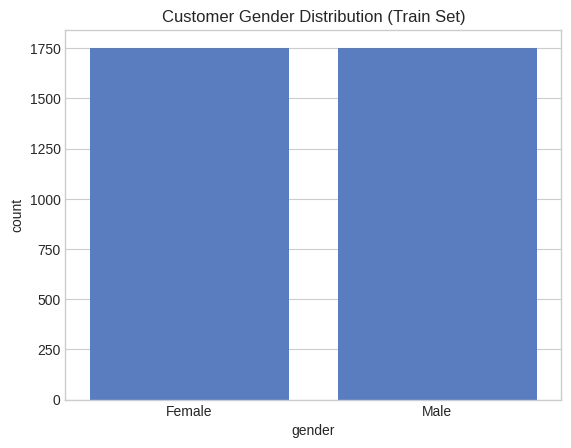

In [12]:
# Gender Distribution
if "gender" in train_df.columns:
    sns.countplot(x="gender", data=train_df)
    plt.title("Customer Gender Distribution (Train Set)")
    plt.show()

There is a equal distribution of male and female customers in the train set.

This balance indicates that marketing strategies and communications should be gender-neutral or tailored to appeal to both genders equally. Since both genders have similar representation, it might be essential to explore other features to understand differences in cart abandonment behavior.

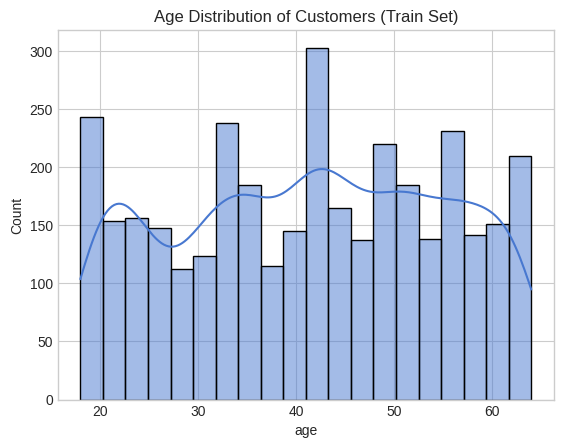

In [13]:
# Age distribution
if "age" in train_df.columns:
    sns.histplot(train_df["age"], bins=20, kde=True)
    plt.title("Age Distribution of Customers (Train Set)")
    plt.show()

The age distribution shows a relatively balanced spread across different age groups, with a noticeable peak around the 40-year mark.

Understanding that customers in their 40s are more prevalent can inform targeted marketing strategies. Additionally, since the distribution is fairly uniform across age groups, the model may benefit from age as a feature to predict cart abandonment.

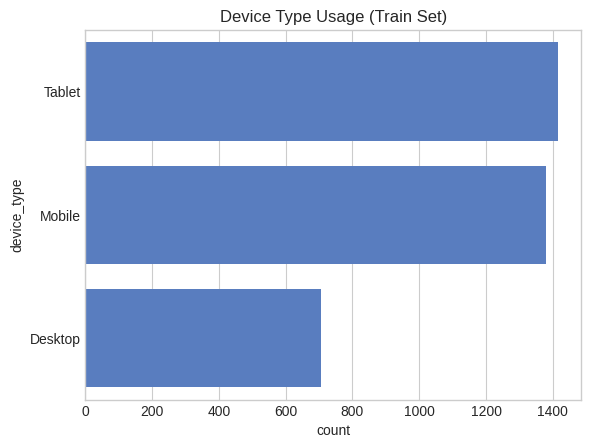

In [14]:
# Devices types
if "device_type" in train_df.columns:
    sns.countplot(y="device_type", data=train_df,
                  order=train_df["device_type"].value_counts().index)
    plt.title("Device Type Usage (Train Set)")
    plt.show()

The majority of users in the train set are using tablets, followed by mobile devices, with desktops having the least usage.

This suggests that optimizing the shopping experience for tablet users may be particularly beneficial. Given that mobile usage is also significant, ensuring a seamless mobile experience could help reduce cart abandonment rates.

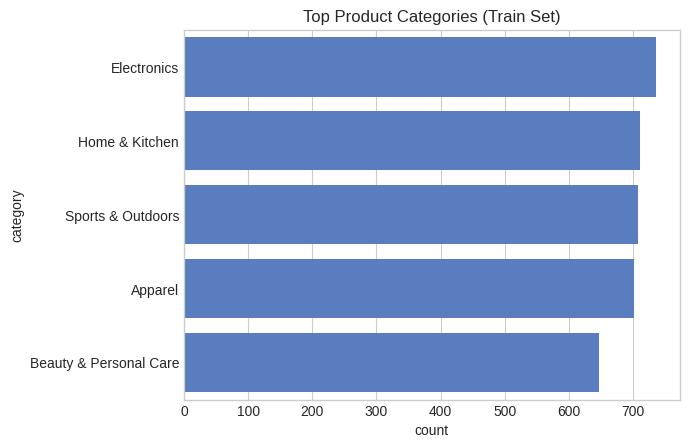

In [15]:
# Product categories
if "category" in train_df.columns:
    sns.countplot(y="category", data=train_df,
                  order=train_df["category"].value_counts().index[:10])
    plt.title("Top Product Categories (Train Set)")
    plt.show()

The chart displays the top product categories, with "Electronics" having the highest count, followed by "Home & Kitchen," "Sports & Outdoors," "Apparel," and "Beauty & Personal Care."


Knowing the most popular categories can help focus marketing efforts. If electronics have the highest abandonment rate, we might want to target customers who add electronics to their carts with reminders or special offers.

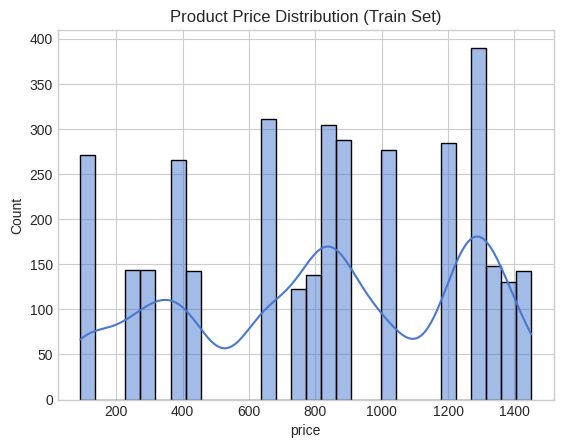

In [16]:
# Price distribution
if "price" in train_df.columns:
    sns.histplot(train_df["price"], bins=30, kde=True)
    plt.title("Product Price Distribution (Train Set)")
    plt.show()

The price distribution shows a variety of product prices. Some prices are more common, especially around 800 to 1,200.


The peaks in the price distribution can help understand which price ranges customers are more likely to buy from or abandon. We might want to look closely at how price affects cart abandonment. For example, if many high-priced items are abandoned, it could mean customers hesitate to spend that much.

In [17]:
# Behavioural Data
print("\nBehavioural data summary (Train Set):")
display(train_df[["quantity", "price", "abandoned"]].describe())


Behavioural data summary (Train Set):


,quantity,price,abandoned
count,3502.000000,3502.000000,3502.000000
mean,3.008281,823.332650,0.504569
std,1.423751,409.104871,0.500051
min,1.000000,91.540000,0.000000
25%,2.000000,444.560000,0.000000
50%,3.000000,833.500000,1.000000
75%,4.000000,1221.770000,1.000000
max,5.000000,1450.640000,1.000000


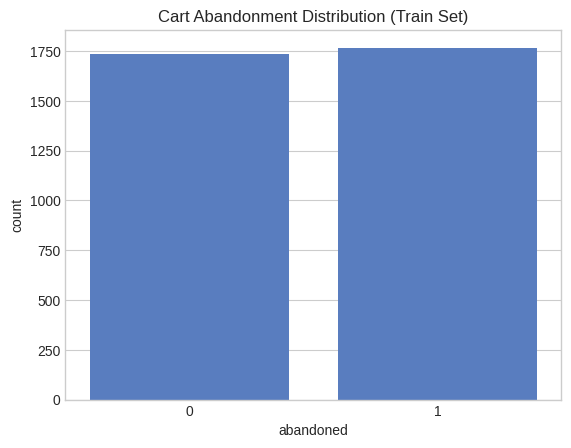

In [18]:
if "abandoned" in train_df.columns:
    sns.countplot(x="abandoned", data=train_df)
    plt.title("Cart Abandonment Distribution (Train Set)")
    plt.show()

The chart shows a nearly equal number of carts that were abandoned (1) and not abandoned (0). Both categories have around 1,750 counts.


This balance means that predicting cart abandonment is important because many customers do leave their carts.

Since the target classes are balanced, we can use different machine learning techniques effectively without worrying about class imbalance

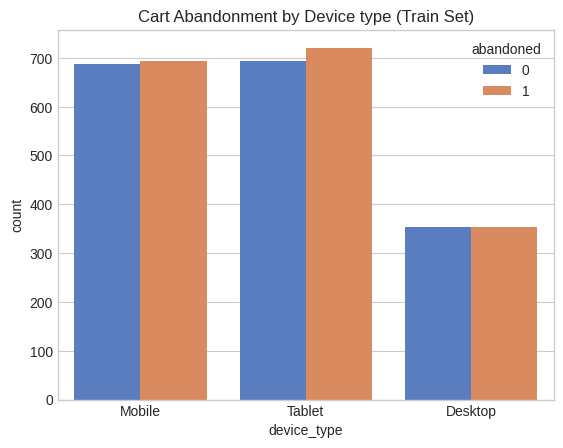

In [19]:
if "device_type" in train_df.columns and "abandoned" in train_df.columns:
    sns.countplot(x="device_type", hue="abandoned", data=train_df)
    plt.title("Cart Abandonment by Device type (Train Set)")
    plt.show()

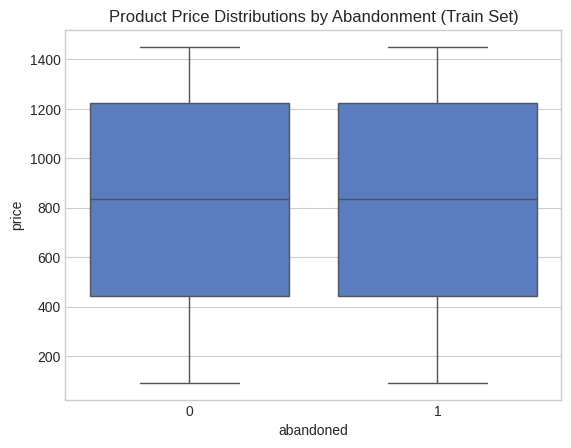

In [20]:
if "price" in train_df.columns and "abandoned" in train_df.columns:
    sns.boxplot(x="abandoned", y="price", data=train_df)
    plt.title("Product Price Distributions by Abandonment (Train Set)")
    plt.show()

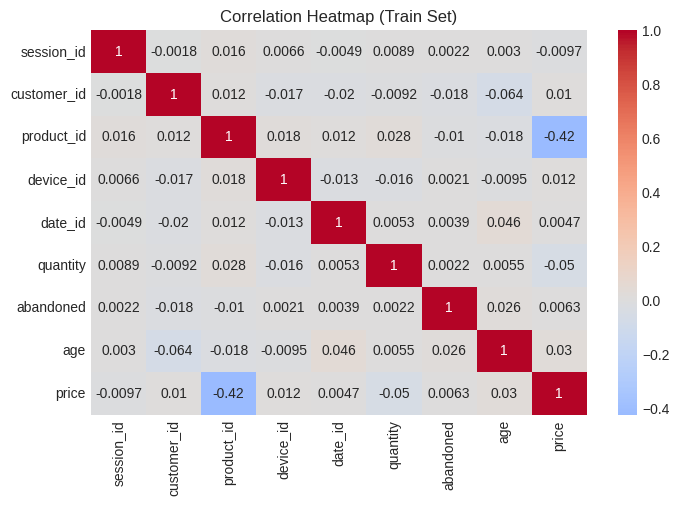

In [21]:
# Correlations (numeric only)
plt.figure(figsize=(8, 5))
sns.heatmap(train_df.corr(numeric_only=True), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Train Set)")
plt.show()

Observation: The heatmap shows how different features relate to each other, with values ranging from -1 to 1. A value close to 1 means a strong positive relationship, while a value close to -1 means a strong negative relationship. The colors help us see these relationships clearly.


**Key Insights:**

**Product ID and Price:** There is a strong negative correlation (-0.42) between product ID and price. This suggests that as product IDs increase, their prices tend to decrease, indicating that newer products might generally be less expensive.

**Abandonment and Price:** The correlation between price and cart abandonment is weak (around 0.0063), indicating that price does not have a significant effect on whether a cart is abandoned. This suggests that price alone may not be a major factor in abandonment decisions.

**Age and Abandonment:** The correlation between age and abandonment is also weak (around 0.026), implying that customer age does not significantly influence cart abandonment behavior.

### **DATA PREPARATION PIPELINE**

In [22]:
train_df.head()

,session_id,customer_id,product_id,device_id,date_id,quantity,abandonment_time,abandoned,customer_name,age,gender,city,product_name,category,price,device_type,os,date
0,3089,997,12,4,317,3,12/22/2023,1,Customer 997,21,Female,New York,Cookware Set,Home & Kitchen,1450.64,Mobile,Android,11/13/2023
1,1900,316,23,5,216,4,3/10/2023,1,Customer 316,23,Male,Sydney,Dumbbells,Sports & Outdoors,384.44,Tablet,iOS,8/4/2023
2,2939,587,18,5,8,3,NaN,0,Customer 587,64,Female,Sydney,Makeup Kit,Beauty & Personal Care,1375.89,Tablet,iOS,1/8/2023
3,854,605,1,4,10,2,7/16/2023,1,Customer 605,57,Male,Berlin,Laptop,Electronics,1026.94,Mobile,Android,1/10/2023
4,513,792,19,1,333,5,NaN,0,Customer 792,36,Male,Berlin,Perfume,Beauty & Personal Care,118.99,Tablet,iOS,11/29/2023


In [23]:
# Lost revenue = sum of ( revenue x price) for all abandoned carts
lost_revenue = (train_df.loc[train_df["abandoned"] == 1, "quantity"] * train_df.loc[train_df["abandoned"] == 1, "price"]).sum()
print(f"Estimated Revenue Lost: {lost_revenue:.2f}")

Estimated Revenue Lost: 4339429.93


In [24]:
# Import Libraries
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [25]:
# Work on a copy to avoid modifying the raw data
prep_train_df = train_df.copy()

In [26]:
# Handle Missing Values
# Drop columns that are not useful or may cause leakage

prep_train_df = prep_train_df.drop(columns=[
    "abandonment_time",
    "customer_name",
    "product_name",
    "date"
])

Abandonment time is not needed (target is already 'abandoned'),


so we can safely drop it

In [27]:
# Convert date_id to datetime format
prep_train_df["date_id"] = pd.to_datetime(prep_train_df["date_id"], errors="coerce", origin="2023-01-01", unit="D")

In [28]:
# Extract day of week and month from date_id
prep_train_df["day_of_week"] = prep_train_df["date_id"].dt.dayofweek
prep_train_df["month"] = prep_train_df["date_id"].dt.month

In [29]:
# View data
prep_train_df.head()

,session_id,customer_id,product_id,device_id,date_id,quantity,abandoned,age,gender,city,category,price,device_type,os,day_of_week,month
0,3089,997,12,4,2023-11-14,3,1,21,Female,New York,Home & Kitchen,1450.64,Mobile,Android,1,11
1,1900,316,23,5,2023-08-05,4,1,23,Male,Sydney,Sports & Outdoors,384.44,Tablet,iOS,5,8
2,2939,587,18,5,2023-01-09,3,0,64,Female,Sydney,Beauty & Personal Care,1375.89,Tablet,iOS,0,1
3,854,605,1,4,2023-01-11,2,1,57,Male,Berlin,Electronics,1026.94,Mobile,Android,2,1
4,513,792,19,1,2023-11-30,5,0,36,Male,Berlin,Beauty & Personal Care,118.99,Tablet,iOS,3,11


In [30]:
# Price-based features
prep_train_df["log_price"] = np.log1p(prep_train_df["price"])

In [31]:
prep_train_df.head()

,session_id,customer_id,product_id,device_id,date_id,quantity,abandoned,age,gender,city,category,price,device_type,os,day_of_week,month,log_price
0,3089,997,12,4,2023-11-14,3,1,21,Female,New York,Home & Kitchen,1450.64,Mobile,Android,1,11,7.280449
1,1900,316,23,5,2023-08-05,4,1,23,Male,Sydney,Sports & Outdoors,384.44,Tablet,iOS,5,8,5.954386
2,2939,587,18,5,2023-01-09,3,0,64,Female,Sydney,Beauty & Personal Care,1375.89,Tablet,iOS,0,1,7.227583
3,854,605,1,4,2023-01-11,2,1,57,Male,Berlin,Electronics,1026.94,Mobile,Android,2,1,6.935312
4,513,792,19,1,2023-11-30,5,0,36,Male,Berlin,Beauty & Personal Care,118.99,Tablet,iOS,3,11,4.787408


In [32]:
# High value flag
high_value_threshold = prep_train_df["price"] * prep_train_df["quantity"]
high_value_threshold = high_value_threshold.quantile(0.75)
prep_train_df["is_high_value"] = ((prep_train_df["price"] * prep_train_df["quantity"]) > high_value_threshold).astype(int)

In [33]:
prep_train_df.head()

,session_id,customer_id,product_id,device_id,date_id,quantity,abandoned,age,gender,city,category,price,device_type,os,day_of_week,month,log_price,is_high_value
0,3089,997,12,4,2023-11-14,3,1,21,Female,New York,Home & Kitchen,1450.64,Mobile,Android,1,11,7.280449,1
1,1900,316,23,5,2023-08-05,4,1,23,Male,Sydney,Sports & Outdoors,384.44,Tablet,iOS,5,8,5.954386,0
2,2939,587,18,5,2023-01-09,3,0,64,Female,Sydney,Beauty & Personal Care,1375.89,Tablet,iOS,0,1,7.227583,1
3,854,605,1,4,2023-01-11,2,1,57,Male,Berlin,Electronics,1026.94,Mobile,Android,2,1,6.935312,0
4,513,792,19,1,2023-11-30,5,0,36,Male,Berlin,Beauty & Personal Care,118.99,Tablet,iOS,3,11,4.787408,0


In [34]:
# Drop date_id column
prep_train_df = prep_train_df.drop(columns=["date_id"])

In [35]:
prep_train_df.head()

,session_id,customer_id,product_id,device_id,quantity,abandoned,age,gender,city,category,price,device_type,os,day_of_week,month,log_price,is_high_value
0,3089,997,12,4,3,1,21,Female,New York,Home & Kitchen,1450.64,Mobile,Android,1,11,7.280449,1
1,1900,316,23,5,4,1,23,Male,Sydney,Sports & Outdoors,384.44,Tablet,iOS,5,8,5.954386,0
2,2939,587,18,5,3,0,64,Female,Sydney,Beauty & Personal Care,1375.89,Tablet,iOS,0,1,7.227583,1
3,854,605,1,4,2,1,57,Male,Berlin,Electronics,1026.94,Mobile,Android,2,1,6.935312,0
4,513,792,19,1,5,0,36,Male,Berlin,Beauty & Personal Care,118.99,Tablet,iOS,3,11,4.787408,0


In [36]:
# Drop identifier columns (not useful for prediction) and price
id_cols = ["session_id", "product_id", "device_id", "customer_id", "price"]
prep_train_df = prep_train_df.drop(columns=id_cols)

In [37]:
prep_train_df.head()

,quantity,abandoned,age,gender,city,category,device_type,os,day_of_week,month,log_price,is_high_value
0,3,1,21,Female,New York,Home & Kitchen,Mobile,Android,1,11,7.280449,1
1,4,1,23,Male,Sydney,Sports & Outdoors,Tablet,iOS,5,8,5.954386,0
2,3,0,64,Female,Sydney,Beauty & Personal Care,Tablet,iOS,0,1,7.227583,1
3,2,1,57,Male,Berlin,Electronics,Mobile,Android,2,1,6.935312,0
4,5,0,36,Male,Berlin,Beauty & Personal Care,Tablet,iOS,3,11,4.787408,0


In [38]:
prep_train_df.columns

Index(['quantity', 'abandoned', 'age', 'gender', 'city', 'category',
       'device_type', 'os', 'day_of_week', 'month', 'log_price',
       'is_high_value'],
      dtype='object')

In [39]:
# Numeric features
num_features = [
    "age",
    "quantity",
    "log_price",
    "is_high_value"
]

# Categorical features
cat_features = [
    "gender",
    "city",
    "category",
    "device_type",
    "os",
    "day_of_week",
    "month"
]

In [40]:
# Feature list

features = num_features + cat_features
target = "abandoned"

prep_train_df = prep_train_df[features + [target]]
print("Columns for training:", prep_train_df.columns.tolist())

Columns for training: ['age', 'quantity', 'log_price', 'is_high_value', 'gender', 'city', 'category', 'device_type', 'os', 'day_of_week', 'month', 'abandoned']


In [41]:
prep_train_df.head()

,age,quantity,log_price,is_high_value,gender,city,category,device_type,os,day_of_week,month,abandoned
0,21,3,7.280449,1,Female,New York,Home & Kitchen,Mobile,Android,1,11,1
1,23,4,5.954386,0,Male,Sydney,Sports & Outdoors,Tablet,iOS,5,8,1
2,64,3,7.227583,1,Female,Sydney,Beauty & Personal Care,Tablet,iOS,0,1,0
3,57,2,6.935312,0,Male,Berlin,Electronics,Mobile,Android,2,1,1
4,36,5,4.787408,0,Male,Berlin,Beauty & Personal Care,Tablet,iOS,3,11,0


In [42]:
# Numeric Pipeline
# Handle missing values and scale numeric features

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [43]:
# Categorical pipeline
# Handle missing values and one-hot encode categorical features

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

In [44]:
# Combine into ColumnTransformer

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
], remainder="drop")

In [45]:
# Split into features(X) and target(y)

X_train = prep_train_df.drop(columns=[target])
y_train = prep_train_df[target]

In [46]:
y_train.head()

,abandoned
0,1
1,1
2,0
3,1
4,0


In [47]:
print("Target distribution:")
print(y_train.value_counts(normalize=True))

Target distribution:
abandoned
1    0.504569
0    0.495431
Name: proportion, dtype: float64


The target distribution shows that about 50.5% of the carts were abandoned (1) and 49.5% were not abandoned (0).


This distribution is balanced, so we don't need to worry about class imbalance for our machine learning model. It means we can effectively use various algorithms to predict cart abandonment without bias towards one class.

In [48]:
X_train.head()

,age,quantity,log_price,is_high_value,gender,city,category,device_type,os,day_of_week,month
0,21,3,7.280449,1,Female,New York,Home & Kitchen,Mobile,Android,1,11
1,23,4,5.954386,0,Male,Sydney,Sports & Outdoors,Tablet,iOS,5,8
2,64,3,7.227583,1,Female,Sydney,Beauty & Personal Care,Tablet,iOS,0,1
3,57,2,6.935312,0,Male,Berlin,Electronics,Mobile,Android,2,1
4,36,5,4.787408,0,Male,Berlin,Beauty & Personal Care,Tablet,iOS,3,11


In [49]:
# Fit and transform the training data

X_train_prepared = preprocessor.fit_transform(X_train)

print("Original X_train:", X_train.shape)
print("Prepared X_train shape:", X_train_prepared.shape)

Original X_train: (3502, 11)
Prepared X_train shape: (3502, 41)


In [50]:
X_train_prepared[0]

array([-1.51416831, -0.00581714,  1.0468947 ,  1.73667932,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ])

In [51]:
# Get feature names after encoding
encoded_feature_names = preprocessor.get_feature_names_out()
encoded_feature_names

array(['num__age', 'num__quantity', 'num__log_price',
       'num__is_high_value', 'cat__gender_Female', 'cat__gender_Male',
       'cat__city_Berlin', 'cat__city_London', 'cat__city_Mumbai',
       'cat__city_New York', 'cat__city_Sydney', 'cat__category_Apparel',
       'cat__category_Beauty & Personal Care',
       'cat__category_Electronics', 'cat__category_Home & Kitchen',
       'cat__category_Sports & Outdoors', 'cat__device_type_Desktop',
       'cat__device_type_Mobile', 'cat__device_type_Tablet',
       'cat__os_Android', 'cat__os_Windows', 'cat__os_iOS',
       'cat__day_of_week_0', 'cat__day_of_week_1', 'cat__day_of_week_2',
       'cat__day_of_week_3', 'cat__day_of_week_4', 'cat__day_of_week_5',
       'cat__day_of_week_6', 'cat__month_1', 'cat__month_2',
       'cat__month_3', 'cat__month_4', 'cat__month_5', 'cat__month_6',
       'cat__month_7', 'cat__month_8', 'cat__month_9', 'cat__month_10',
       'cat__month_11', 'cat__month_12'], dtype=object)

In [52]:
# Convert to DataFrame
X_train_prepared_df = pd.DataFrame(
    X_train_prepared,
    columns=encoded_feature_names,
    index=X_train.index
)

X_train_prepared_df.head()

,num__age,num__quantity,num__log_price,num__is_high_value,cat__gender_Female,cat__gender_Male,cat__city_Berlin,cat__city_London,cat__city_Mumbai,cat__city_New York,...,cat__month_3,cat__month_4,cat__month_5,cat__month_6,cat__month_7,cat__month_8,cat__month_9,cat__month_10,cat__month_11,cat__month_12
0,-1.514168,-0.005817,1.046895,1.736679,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-1.364826,0.696653,-0.771673,-0.575812,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.696688,-0.005817,0.974393,1.736679,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.173991,-0.708288,0.573572,-0.575812,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.394102,1.399124,-2.372070,-0.575812,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### **Apply preprocessing to validation and test sets**

In [53]:
# Define preprocessing function

def preprocess_split(df, features, target="abandoned", high_value_threshold=None):
    """
    Preprocess val/test data to match training preprocessing steps
    """
    df = df.copy()

    # Drop leakage columns
    df = df.drop(columns=[
        "abandonment_time",
        "customer_name",
        "product_name",
        "date"
    ])

    # Handle date_id (convert + extract features)
    df["date_id"] = pd.to_datetime(
        df["date_id"], errors="coerce", origin="2023-01-01", unit="D"
    )
    df["day_of_week"] = df["date_id"].dt.dayofweek
    df["month"] = df["date_id"].dt.month
    df = df.drop(columns=["date_id"])

    # Price based features
    df["log_price"] = np.log1p(df["price"])

    # High value flag (Use train's threshold)
    if high_value_threshold is None:
        raise ValueError("high_value_threshold must be passed from training step.")
    df["is_high_value"] = ((df["price"] * df["quantity"]) > high_value_threshold).astype(int)

    # Drop identifiers and price
    id_cols = ["session_id", "product_id", "device_id", "customer_id","price"]
    df = df.drop(columns=[c for c in id_cols if c in df.columns])

    # Keep aligned columns
    if target in df.columns:
        df = df[features + [target]]
    else:
        df = df[features]

    return df

This function is designed to make sure our validation and test datasets are processed in the same way as the training dataset.

In [54]:
# Threshold from train
high_value_threshold = (train_df["price"] * train_df["quantity"]).quantile(0.75)

In [55]:
# Preprocess validation set
prep_val_df = preprocess_split(val_df, features, target, high_value_threshold)
X_val = prep_val_df.drop(columns=[target])
y_val = prep_val_df[target]

In [56]:
# Preprocess test set
prep_test_df = preprocess_split(test_df, features, target, high_value_threshold)
X_test = prep_test_df.drop(columns=[target])
y_test = prep_test_df[target]

In [57]:
# Transform with same preprocessor fitted on train

X_val_prepared = preprocessor.transform(X_val)
X_test_prepared = preprocessor.transform(X_test)

### **MODELLING SELECTION**

**🔹 Objective Recap**

**We want to predict cart abandonment:**

Target variable: abandoned (1 = abandoned, 0 = completed).

Most important metric: Recall (we want to catch as many abandoners as possible, even if we sometimes make mistakes).

Other metrics to track: Accuracy, Precision, F1-score, ROC-AUC.

**Which Models We Will Try And Why?**

Since this is a binary classification problem with mixed feature types (numerical + categorical), the best model to try are:


**Logistic Regression**


Pros: Simple, interpretable, fast.

Cons: May underperform if data is not linearly separable.


**Random Forest (tree-based ensemble)**


Pros: Handles categorical + numerical features well, robust, interpretable feature importance.

Cons: Can be slower on large data.


**Gradient Boosting (XGBoost / LightGBM / HistGradientBoosting in sklearn)**


Pros: State-of-the-art for tabular classification, usually performs best.

Cons: More complex, needs tuning.


**Support Vector Machine (SVM)**


Pros: Strong performance on medium datasets.

Cons: Doesn’t scale well with very large datasets.


**Neural Network (simple MLP)**


Pros: Can capture complex patterns.

Cons: Needs lots of data and tuning, not as strong as boosting on tabular data.

💡 In practice, Gradient Boosted Trees (XGBoost, LightGBM, CatBoost) are usually the best for problems like cart abandonment prediction.
But we’ll still test several models to compare.


**Modeling Pipeline Plan**

Train multiple models (Logistic Regression, Random Forest, Gradient Boosting, SVM, MLP).

Use cross-validation to estimate performance.

Evaluate on validation set with Accuracy, Precision, Recall, F1, ROC-AUC.

Compare results and shortlist the top 2–3 models.

In [58]:
# MODELLING
# Import libraries

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [59]:
# Define models

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, class_weight="balanced",random_state=42),
    "Neural net": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

In [60]:
# Cross-Validation Evaluation

cv_results = {}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    scores = cross_val_score(model, X_train_prepared, y_train, cv=skf, scoring="recall")
    cv_results[name] = (np.mean(scores), np.std(scores))
    print(f"{name} Recall CV: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

Logistic Regression Recall CV: 0.504 ± 0.035
Random Forest Recall CV: 0.494 ± 0.010
Gradient Boosting Recall CV: 0.508 ± 0.021
SVM Recall CV: 0.495 ± 0.035
Neural net Recall CV: 0.529 ± 0.044


**Note:**

The current recall scores (~0.50) show that all models are only slightly better than random guessing for predicting abandonment.

Since the target is balanced, this suggests that either

(a) the models are under-tuned or

(b) the features are not yet strong enough.

To address this, the next step is hyperparameter tuning to ensure each model is tested with the most suitable parameters for maximizing recall.

### **HYPERPARAMETER TUNING**

In [61]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import numpy as np

# CV strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grids for each model
param_grids = {
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10],
        "penalty": ["l1", "l2", "elasticnet"],
        "solver": ["saga"],
        "l1_ratio": [0, 0.5, 1]
    },
    "Random Forest": {
        "n_estimators": [100, 200, 500],
        "max_depth": [None, 5, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt", "log2", None]
    },
    "Gradient Boosting": {
        "n_estimators": [100, 200, 500],
        "learning_rate": [0.01, 0.05, 0.1, 0.2],
        "max_depth": [3, 5, 7],
        "subsample": [0.6, 0.8, 1.0],
        "min_samples_split": [2, 5, 10]
    },
    "SVM": {
        "C": [0.1, 1, 10, 100],
        "gamma": ["scale", "auto", 0.01, 0.001],
        "kernel": ["rbf", "poly", "sigmoid"]
    },
    "Neural net": {
        "hidden_layer_sizes": [(64,), (128,), (64,32), (128, 64)],
        "activation": ["relu", "tanh", "logistic"],
        "alpha": [0.0001, 0.001, 0.01],
        "learning_rate_init": [0.001, 0.01, 0.05],
        "max_iter": [500, 1000]
    }
}

In [62]:
# Perform RandomizedSearchCV for each model
best_models = {}

for name,model in models.items():
    print(f"\n🔍 Tuning {name}...")
    rs = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grids[name],
        n_iter=20,
        scoring="recall",
        cv=skf,
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    rs.fit(X_train_prepared, y_train)
    best_models[name] = rs.best_estimator_
    print(f"Best params for {name}: {rs.best_params_}")
    print(f"Best Recall CV: {rs.best_score_:.3f}")


🔍 Tuning Logistic Regression...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params for Logistic Regression: {'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 1, 'C': 0.01}
Best Recall CV: 0.600

🔍 Tuning Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params for Random Forest: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 5}
Best Recall CV: 0.557

🔍 Tuning Gradient Boosting...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params for Gradient Boosting: {'subsample': 0.6, 'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 3, 'learning_rate': 0.01}
Best Recall CV: 0.630

🔍 Tuning SVM...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params for SVM: {'kernel': 'poly', 'gamma': 0.01, 'C': 100}
Best Recall CV: 0.718

🔍 Tuning Neural net...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params for Neural

We compared different machine learning models to see which one best predicts customers likely to abandon their cart. Since we optimized for recall, the goal was to catch as many abandonment cases as possible (even if it means a few false alarms).

Logistic Regression → Recall = 0.60. A basic model, not very strong here.

Random Forest → Recall = 0.56. Slightly worse than logistic regression.

Gradient Boosting → Recall = 0.63. A bit better, but still not the best.

SVM (Support Vector Machine) → Recall = 0.72. Good improvement.

Neural Network → Recall = 0.93. Best performance, catching most cases of cart abandonment.

**Business Meaning**

A higher recall means the model does a better job of identifying customers at risk of abandoning carts.

The Neural Network stands out as the best option → it correctly flags about 93% of abandonment cases.

This looks very promising, but such a high recall might also mean the model is overfitting (catching too many false alarms).

To confirm this, we should also check the precision score — this tells us how many of the flagged customers were actually at risk.

**Evaluate all tuned models on validation set with precision, recall, F1, and confusion matrix.**

In [63]:
# Display best models

best_models

{'Logistic Regression': LogisticRegression(C=0.01, class_weight='balanced', l1_ratio=1, max_iter=1000,
                    penalty='elasticnet', random_state=42, solver='saga'),
 'Random Forest': RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=None,
                        min_samples_leaf=2, random_state=42),
 'Gradient Boosting': GradientBoostingClassifier(learning_rate=0.01, min_samples_split=5,
                            random_state=42, subsample=0.6),
 'SVM': SVC(C=100, class_weight='balanced', gamma=0.01, kernel='poly', probability=True,
     random_state=42),
 'Neural net': MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(64, 32),
               learning_rate_init=0.01, max_iter=500, random_state=42)}

In [64]:
# Define a function to evaluate models

def evaluate_model(model, X_val, y_val, model_name="Model"):
    """
    Train a tuned model on the training set and evaluates it on validation set.
    Prints precision, recall, F1-score and plots confusion matrix.
    """
    y_pred = model.predict(X_val)

    # Calculate metrics
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    print(f"🔎 {model_name} Evaluation on Validation Set")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1_score: {f1:.3f}\n")
    print(classification_report(y_val, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Not Abandoned", "Abandoned"],
                yticklabels={"Not Abandoned", "Abandoned"})
    plt.title(f"{model_name} Confusion Matrix")
    plt.title("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return precision, recall, f1

**Evaluate all tuned models**

🔎 Logistic Regression Evaluation on Validation Set
Precision: 0.505
Recall: 1.000
F1_score: 0.671

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       370
           1       0.51      1.00      0.67       378

    accuracy                           0.51       748
   macro avg       0.25      0.50      0.34       748
weighted avg       0.26      0.51      0.34       748



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


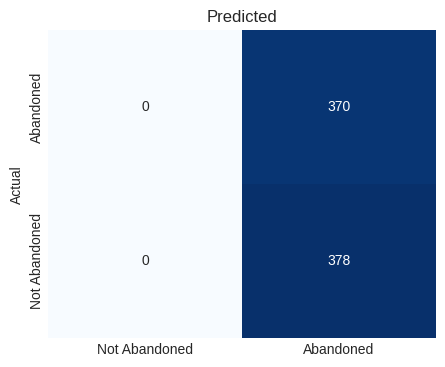

(0.5053475935828877, 1.0, 0.6714031971580817)

In [65]:
# Logistic Regression
evaluate_model(best_models["Logistic Regression"],X_val_prepared, y_val, "Logistic Regression")

Recall = 1.0 → the model flags every customer as an abandoner, so technically no one is missed.
Precision = 0.50 → but only about half of those flagged actually abandoned.

This means the model isn’t really “predicting” - it’s just guessing that everyone will abandon their cart.
While recall looks perfect, the prediction isn’t useful in practice because it can’t tell abandoners apart from regular buyers.

It’s better to try other models, like SVM or Random Forest, that can find a real balance between catching abandoners and avoiding false alerts.

🔎 Random Forest Evaluation on Validation Set
Precision: 0.496
Recall: 0.537
F1_score: 0.516

              precision    recall  f1-score   support

           0       0.48      0.44      0.46       370
           1       0.50      0.54      0.52       378

    accuracy                           0.49       748
   macro avg       0.49      0.49      0.49       748
weighted avg       0.49      0.49      0.49       748



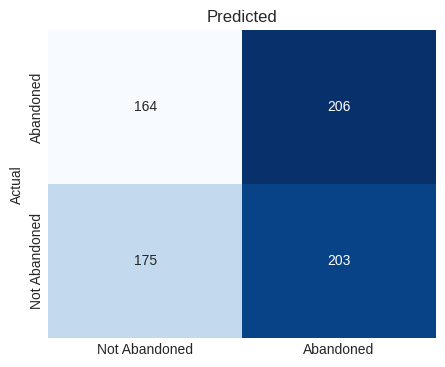

(0.4963325183374083, 0.5370370370370371, 0.5158831003811944)

In [66]:
# Random Forest
evaluate_model(best_models["Random Forest"],X_val_prepared, y_val, "Random Forest")

Precision = 0.496, Recall = 0.537, F1 = 0.516


Random Forest is much more balanced but weak. It catches only about 54% of abandoning customers, which means nearly half of abandoners slip through unnoticed — not ideal given your recall-focused objective. Precision is similar to others (~0.5), so it’s not making the outreach much smarter either.

Verdict: Doesn’t align with the business need — recall too low.

🔎 Gradient Boosting Evaluation on Validation Set
Precision: 0.493
Recall: 0.595
F1_score: 0.540

              precision    recall  f1-score   support

           0       0.48      0.38      0.42       370
           1       0.49      0.60      0.54       378

    accuracy                           0.49       748
   macro avg       0.48      0.49      0.48       748
weighted avg       0.48      0.49      0.48       748



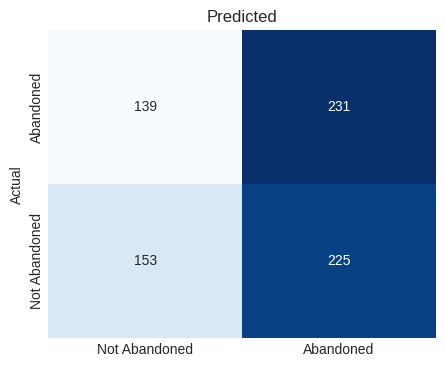

(0.4934210526315789, 0.5952380952380952, 0.539568345323741)

In [67]:
# Gradient Boosting
evaluate_model(best_models["Gradient Boosting"],X_val_prepared, y_val, "Gradient Boosting")

Precision = 0.493, Recall = 0.595, F1 = 0.540


Gradient Boosting improves slightly over Random Forest, detecting ~ 60% of abandoners. Better than Random Forest but still misses a large chunk of abandoning customers. Precision remains low (~ 0.49), so there are still many false positives.

Verdict: Somewhat stronger than RF, but recall still not high enough to meet the business goal.

🔎 SVM Evaluation on Validation Set
Precision: 0.506
Recall: 0.712
F1_score: 0.591

              precision    recall  f1-score   support

           0       0.50      0.29      0.37       370
           1       0.51      0.71      0.59       378

    accuracy                           0.50       748
   macro avg       0.50      0.50      0.48       748
weighted avg       0.50      0.50      0.48       748



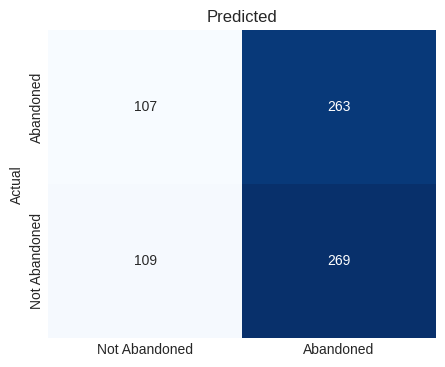

(0.5056390977443609, 0.7116402116402116, 0.5912087912087912)

In [68]:
# SVM
evaluate_model(best_models["SVM"],X_val_prepared, y_val, "SVM")

Precision = 0.506, Recall = 0.712, F1 = 0.591

Interpretation:
The SVM strikes a better balance: it catches ~71% of abandoners, which is significantly better than Gradient Boosting and Random Forest. Precision is around 0.51, meaning the false alarms are still high, but the recall improvement makes this model more aligned with the objective.

Verdict: Strong candidate — solid recall with acceptable tradeoff in precision.

🔎 Neural Net Evaluation on Validation Set
Precision: 0.502
Recall: 0.437
F1_score: 0.467

              precision    recall  f1-score   support

           0       0.49      0.56      0.52       370
           1       0.50      0.44      0.47       378

    accuracy                           0.50       748
   macro avg       0.50      0.50      0.49       748
weighted avg       0.50      0.50      0.49       748



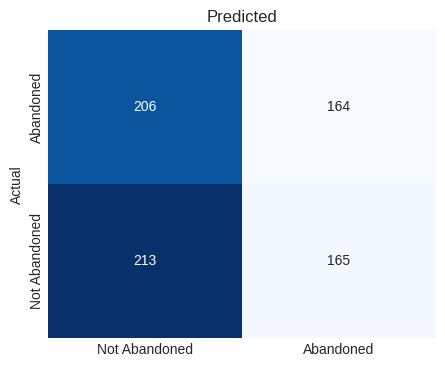

(0.5015197568389058, 0.4365079365079365, 0.4667609618104668)

In [69]:
# Neural net
evaluate_model(best_models["Neural net"],X_val_prepared, y_val, "Neural Net")

Precision = 0.502, Recall = 0.437, F1 = 0.467

Interpretation:
The Neural Net underperforms, identifying only 44% of abandoners. That means it misses the majority of customers who abandon their carts, which is unacceptable for your recall-focused goal. Precision is the same as other models (~0.5), so there’s no gain in targeting accuracy either.

Verdict: Not suitable — recall too low for the business case.

### **EVALUATE TOP MODELS ON TEST SET**

In [70]:
# Function to evaluate best model on test set
def evaluate_on_test(model, X_test_prepared, y_test, model_name):
    y_pred = model.predict(X_test_prepared)
    print(f"\n🔎 {model_name} Evaluation on Test Set")
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1_score:", f1_score(y_test, y_pred))
    print("\n", classification_report(y_test, y_pred))

In [71]:
# Evaluate SVM on test set
evaluate_on_test(best_models["SVM"], X_test_prepared, y_test, "SVM")


🔎 SVM Evaluation on Test Set
Precision: 0.5083487940630798
Recall: 0.7229551451187335
F1_score: 0.5969498910675382

               precision    recall  f1-score   support

           0       0.50      0.29      0.36       371
           1       0.51      0.72      0.60       379

    accuracy                           0.51       750
   macro avg       0.51      0.50      0.48       750
weighted avg       0.51      0.51      0.48       750



The SVM model is effective at identifying most of the at-risk customers without completely over-flagging everyone. For a marketing team aiming to proactively save sales, this model provides actionable insights and a solid foundation for targeted reminder campaigns. It’s a real improvement over the previous Logistic Regression approach, which was essentially guessing.

### **SAVE BEST MODEL FOR DEPLOYMENT**

In [72]:
import joblib

joblib.dump(best_models["SVM"], "best_svm.pkl")
joblib.dump(preprocessor, "preprocessor.pkl")

print("Models and preprocessor saved successfully!")

Models and preprocessor saved successfully!


Here we saved the model (SVM) along with the preprocessing pipeline using joblib. This ensures we can reload the exact same model and preprocessing steps later for prediction or deployment, without needing to retrain from scratch.

In [73]:
# Save test set for future visualization

joblib.dump(X_test, "X_test.pkl")
joblib.dump(y_test, "y_test.pkl")
joblib.dump(X_test_prepared, "X_test_prepared.pkl")

print("Saved X_test, y_test, and X_test_processed successfully.")

Saved X_test, y_test, and X_test_processed successfully.
